In [1]:
!pip install mp_api pymatgen -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.1.0 requires pydantic!=1.8,!=1.8.1,<1.10.0,>=1.7.4, but you have pydantic 2.7.1 which is incompatible.
spacy 3.4.0 requires pydantic!=1.8,!=1.8.1,<1.10.0,>=1.7.4, but you have pydantic 2.7.1 which is incompatible.
gradient-utils 0.5.0 requires pymongo<4.0.0,>=3.11.0, but you have pymongo 4.7.1 which is incompatible.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ast import literal_eval

import sys
sys.path.append('/notebooks/ranker/src/')


from get_from_mp_api import *

# Read in saved df here

In [3]:
main_df = pd.read_csv("df_full_flat_mat_info.csv", converters={'paper_titles': literal_eval, 'flat_segments': literal_eval})
main_df.set_index("material_id", inplace=True)
main_df.head()

,flat,flat_segments,formula,synth_score,Cluster_ID,cluster_size,sublattice_element,dbcv_cluster,probabilities,paper_titles,experimentally_observed,band_gap,synth_score_2,sub_lattice_structure
material_id,,,,,,,,,,,,,,
mp-7,True,[4],S,0.013924,-1,24875,S,0.846820,0.000000,"[The lattice of rhombohedral sulfur, The cryst...",True,2.2079,0.999939,"{'@module': 'pymatgen.core.structure', '@class..."
mp-25,True,[3],N2,0.127548,63,282,N,0.212178,0.104165,[Electron Diffraction and the Structure of alp...,True,7.3685,0.893845,"{'@module': 'pymatgen.core.structure', '@class..."
mp-35,True,"[1, 2, 3, 4]",Mn,0.007099,-1,24875,Mn,0.846820,0.000000,"[Crystal structure of alpha-manganese, Antifer...",True,0.0000,0.999977,"{'@module': 'pymatgen.core.structure', '@class..."
mp-43,True,"[1, 2, 3, 4]",U,0.001247,-1,24875,U,0.846820,0.000000,[The crystal structure of the beta phase of ur...,True,0.0000,1.000000,"{'@module': 'pymatgen.core.structure', '@class..."
mp-83,True,"[3, 4]",S,0.013924,38,22,S,0.468464,0.972129,[X-Ray Structure Analyses of Two Allotropes of...,True,2.5657,0.999928,"{'@module': 'pymatgen.core.structure', '@class..."


# Find approximately matched superconducting structures
#### We mark if a material has been matched by the 3DSC paper to (usually additionally doped) entries in the SuperCon database
#### Then we count, for each cluster, how many of its members are materials which have been matched 

In [4]:
df_3DSC = pd.read_csv("csv_data/Superconductivity_3DSC_MP.csv", skiprows=1, usecols=['material_id_2', 'synth_doped', 'formula_sc', 'tc'])
df_3DSC.rename(columns={'material_id_2': "material_id", "synth_doped":"SC_doped_from_original", "formula_sc": "SC_formula"}, inplace=True)
df_3DSC.set_index("material_id", inplace=True)
# remove non-superconductors marked with T_c=0
df_3DSC = df_3DSC[df_3DSC['tc'] != 0]
#print(len(df_3DSC))
df_3DSC

,SC_formula,tc,SC_doped_from_original
material_id,,,
mp-978986,Ag0.02Ge2Pd1.98Sr1,2.640000,True
mp-1883,Ag0.15Sn0.85Te1,2.150000,True
mp-978986,Ag0.1Ge2Pd1.9Sr1,2.620000,True
mp-2597,Ag0.1In0.9Te1,1.200000,True
mp-7275,Ag0.2Ba1Si1.8,3.200000,True
...,...,...,...
mp-675,W2Zr1,1.080000,False
mp-21369,W3O1,1.675000,False
mp-79,Zn1,0.850800,False


In [5]:
len(np.unique(df_3DSC.index.to_numpy()))
np_IDs = df_3DSC.index.to_numpy(dtype=str)
print(len(np.unique(np_IDs)))
print(np.where(np.char.startswith(np.unique(np_IDs), 'v', start=1)))
#print(np.where(np.unique(df_3DSC.index.to_numpy())=="")

1524
(array([1522, 1523]),)


# % of all "flat-mats" which are SCs, without any triviality cuts

In [6]:
full_ids = pd.read_csv("csv_data/full_mp_id_list.csv")
full_ids.set_index("Column1", inplace=True)
full_ids_list = full_ids.index.to_numpy()
print(len(full_ids_list))
print(full_ids_list)

70451
['mp-1' 'mp-2' 'mp-3' ... 'mp-1504314' 'mp-1504391' 'mp-1504764']


In [7]:
print(len(main_df.index.unique()))
# Convert arrays to sets
#SCs = set(np.unique(df_3DSC[df_3DSC["SC_doped_from_original"]==False].index.to_numpy()))
SCs = set(np.unique(df_3DSC.index.to_numpy()))

print(len(SCs))
flat_mats = set(np.unique(main_df.index.to_numpy()))
full_ids = set(full_ids_list)

# Find the common elements using intersection
common_flat = SCs.intersection(flat_mats)
common_non_flat = SCs.intersection(full_ids.difference(flat_mats))
flat_check = full_ids.intersection(flat_mats)

# Find the number of common elements
num_common_elements = len(common_flat)
num_common_full = len(common_non_flat)

# print outputs
print("Number of flat materials also in 3DSC:", num_common_elements)
print("Number of 'non-flat' mats also in 3DSC:", num_common_full)
print("Number of flat mats:", len(flat_check))
print("These numbers don't add to the total matched in 3DSC (to mat proj) because not all mat project entries have band-structure data which is a requirement to be in our flat/not flat groups here")

33251
1524
Number of flat materials also in 3DSC: 148
Number of 'non-flat' mats also in 3DSC: 1113
Number of flat mats: 33251
These numbers don't add to the total matched in 3DSC (to mat proj) because not all mat project entries have band-structure data which is a requirement to be in our flat/not flat groups here


# SC %s for "non-insulating"(band_Gap<1eV cut applied) materials
#### also excluding doped cases

In [8]:
non_triv_df = main_df[main_df["band_gap"]<=1]

# Convert arrays to sets
# undoped SCs
#SCs = set(np.unique(df_3DSC[df_3DSC["SC_doped_from_original"]==False].index.to_numpy()))
SCs = set(np.unique(df_3DSC.index.to_numpy()))
# band gap <=1eV flat-mats
non_triv_flat_mats = set(np.unique(non_triv_df.index.to_numpy()))
# full mat id list
full_ids = set(full_ids_list)

# insulating + non-flat mat id list
triv_plus_non_flat = full_ids.difference(non_triv_flat_mats)

# Find the common elements using intersection
num_nontriv_flat_SC = len(SCs.intersection(non_triv_flat_mats))
num_trivial_or_non_flat_SC = len(SCs.intersection(triv_plus_non_flat))
flat_check = full_ids.intersection(flat_mats)

# print outputs
print(num_nontriv_flat_SC)
print(num_trivial_or_non_flat_SC)
#print("doped SC cases been removed: {0}".format())
print("% of SC non-triv flat mats:", (num_nontriv_flat_SC / len(non_triv_flat_mats))*100)
print("% of SC 'non-flat' or insulating mats:", (num_trivial_or_non_flat_SC / len(triv_plus_non_flat))*100)
print("Number of non-triv flat mats:", len(non_triv_flat_mats))
print(len(triv_plus_non_flat))

143
1118
% of SC non-triv flat mats: 0.8957093642342625
% of SC 'non-flat' or insulating mats: 2.0519032411995743
Number of non-triv flat mats: 15965
54486


#### save whether a material is SC matched

In [9]:
# Merge the two dataframes to see how many flat-band materials we have, have been matched with SuperCon database
df_matched_SCs = pd.merge(main_df, df_3DSC, left_index=True, right_index=True, how='inner')
print(len(np.unique(df_matched_SCs.index.to_list())))
#df_matched_SCs.head(20)

148


In [10]:
main_df["matched_to_a_sc"] = False
main_df["SC_doped_from_original"] = "n/a"
main_df.loc[df_matched_SCs.index, 'matched_to_a_sc'] = True

# CHECK THIS WORKS IN ORDER:
main_df.loc[df_matched_SCs.index, 'SC_doped_from_original'] = df_matched_SCs['SC_doped_from_original']

In [11]:
#main_df["SC_doped_from_original"]
df_matched = main_df[main_df["matched_to_a_sc"]]
df_matched["SC_doped_from_original"]

material_id
mp-243        False
mp-491         True
mp-607        False
mp-879        False
mp-1107       False
              ...  
mp-1207780    False
mp-1216453    False
mp-1216639     True
mp-1222913     True
mp-1225166    False
Name: SC_doped_from_original, Length: 148, dtype: object

# triviality metrics analysis - histograms for band gap and atomic distances (see where SCs fall)

In [262]:
from scipy.optimize import curve_fit, fsolve

def cubic_func(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d

def exponential_func(x, a, b, c):
    return a * np.exp(b * x) + c

def intersection(func1, func2, x_guess):
    return fsolve(lambda x: func1(x) - func2(x), x_guess)

def red_chi_squared(observed, expected, error, DoF):
    return np.sum((observed - expected)**2 / error**2) / DoF

def get_selection_cut_histograms_and_power(column, df_var, save, name, log_scale=False, apply_density=False, N_bins=30, ax=None, range_=(0, 1)):
    if not ax:
        fig, ax = plt.subplots()
        
    # Plot histogram for all flat-band materials
    hist_all, bins_all, _ = ax.hist(df_var[column].to_list(), bins=N_bins, range=range_, density=apply_density, alpha=0.7, edgecolor='black', linewidth=1.2, label="All Flat-Band Materials", color='skyblue')
    bin_centers_all = (bins_all[:-1] + bins_all[1:]) / 2
    
    # Calculate errors
    errors = np.sqrt(hist_all)
    
    # Fit cubic function to the range 0.0 to 0.7
    mask_cubic = (bin_centers_all >= 0.0) & (bin_centers_all <= 0.7)
    popt_cubic, _ = curve_fit(cubic_func, bin_centers_all[mask_cubic], np.log(hist_all[mask_cubic]), sigma=errors[mask_cubic])
    x_fit_cubic = np.linspace(0.0, 0.8, 100)
    y_fit_cubic = np.exp(cubic_func(x_fit_cubic, *popt_cubic))
    ax.plot(x_fit_cubic, y_fit_cubic, label='Cubic Fit (0.0-0.7)', color='green')
    
    # Calculate chi-squared for cubic fit
    chi_squared_cubic = red_chi_squared(hist_all[mask_cubic], np.exp(cubic_func(bin_centers_all[mask_cubic], *popt_cubic)), 
                                    error=errors[mask_cubic], DoF=len(mask_cubic)-4)
    print(f'Reduced Chi-squared (cubic): {chi_squared_cubic:.2f}')
    
    # Fit exponential function to the range 0.7 to 1.0 (log scale)
    mask_exponential = (bin_centers_all >= 0.7) & (bin_centers_all <= 0.94)
    popt_exponential, _ = curve_fit(exponential_func, bin_centers_all[mask_exponential], np.log(hist_all[mask_exponential]),
                                    sigma=errors[mask_exponential])
    x_fit_exponential = np.linspace(0.6, 1.0, 100)
    y_fit_exponential = np.exp(exponential_func(x_fit_exponential, *popt_exponential))
    ax.plot(x_fit_exponential, y_fit_exponential, label='Exponential Fit (0.7-0.94)', color='orange')
    
    # Calculate chi-squared for exponential fit
    chi_squared_exponential = red_chi_squared(hist_all[mask_exponential], np.exp(exponential_func(bin_centers_all[mask_exponential], *popt_exponential)),
                                          error=errors[mask_exponential], DoF=len(mask_exponential)-3)
    print(f'Reduced Chi-squared (exponential): {chi_squared_exponential:.2f}')
    
    # Calculate intersection point of the cubic and exponential fits
    intersection_x = intersection(lambda x: cubic_func(x, *popt_cubic), lambda x: exponential_func(x, *popt_exponential), 0.67)
    intersection_y = np.exp(cubic_func(intersection_x, *popt_cubic))
    print(intersection_x)
    ax.scatter(intersection_x, intersection_y, color='red', marker='x', label=f'Intersection ({intersection_x[0]:.2f}, {intersection_y[0]:.2f})')
    print(f'Intersection point, x: ({intersection_x[0]:.3f})')

    # print("cubic - {0}".format([*popt_cubic]))
    # print("exp - {0}".format([*popt_exponential]))
    # Add error bars
    #ax.errorbar(bin_centers_all, hist_all, yerr=errors, fmt='none', color='black', capsize=3)
    
    ax.set_xlabel(column, fontsize=12)
    ax.set_ylabel("Count", fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(fontsize=10)
    
    if log_scale:
        ax.set_yscale("log")
        ax.set_ylabel("ln(count)", fontsize=12)
    
    if save:
        plt.savefig(name, bbox_inches="tight", dpi=500)
    
    return ax

## # triviality metrics analysis - histograms for sublattice charge density overlap (see where SCs fall)

# Full path number density drop metric

In [13]:
drop_scores = pd.read_csv("csv_data/partial_connectivity_metric_data/1_MST_corrected_3_4_mats_sublattice_drops.csv")
#drop_scores = pd.read_csv("all_MST_drop_values_1.csv")
drop_scores.rename(columns={'mat_id': "material_id"}, inplace=True)
drop_scores.set_index("material_id", inplace=True)

drop_scores_2 = pd.read_csv("csv_data/partial_connectivity_metric_data/2_MST_corrected_3_4_mats_sublattice_drops.csv")
#drop_scores_2 = pd.read_csv("all_MST_drop_values_2.csv")
drop_scores_2.rename(columns={'mat_id': "material_id"}, inplace=True)
drop_scores_2.set_index("material_id", inplace=True)

drop_scores_3 = pd.read_csv("csv_data/partial_connectivity_metric_data/3_MST_corrected_3_4_mats_sublattice_drops.csv")
#drop_scores_2 = pd.read_csv("all_MST_drop_values_2.csv")
drop_scores_3.rename(columns={'mat_id': "material_id"}, inplace=True)
drop_scores_3.set_index("material_id", inplace=True)

#comb = drop_scores
comb = pd.concat([drop_scores_3, drop_scores_2, drop_scores])
# Merge the two dataframes, only keep mats for which we have overlap scores for which right now is not all of them
# is about 27k
df_with_drops = pd.merge(main_df, comb, left_index=True, right_index=True, how='inner')
df_with_drops.head()

print(len(df_with_drops.index.to_list()))
print(len(np.unique(df_with_drops.index.to_list())))

29441
29441


### clean scores to remove mats with no chrgcar file
### calculate average of drop scores over full path

In [14]:
def av(arr):
    return np.average(arr)
def w_av(arr):
    return np.average(arr, weights=[arr[i] for i in range(len(arr))])
def max_(arr):
    return np.max(arr)
def min_(arr):
    return np.min(arr)
def list_conv(string):
    return np.fromstring(string[1:-1], dtype=float, sep=',')
def av_cutoff_filter(arr):
    cutoff = 0.2
    return np.average(arr[arr>cutoff])
def remove_lowest(arr):
    cutoff = 4 # as a %
    return np.average(np.sort(arr)[-int(np.round(len(arr)/cutoff)):])

df_with_drops["arr_drop_values"] = df_with_drops["drop_values"].apply(list_conv)

df_with_drops["average_drop"] = df_with_drops["arr_drop_values"].apply(av)
df_with_drops = df_with_drops[df_with_drops["average_drop"]>=0]

df_with_drops["max_drop"] = df_with_drops["arr_drop_values"].apply(max_)
df_with_drops["min_drop"] = df_with_drops["arr_drop_values"].apply(min_)
df_with_drops["w_av_drop"] = df_with_drops["arr_drop_values"].apply(w_av)


# remove mats with no score because no charge density data
df_with_drops = df_with_drops[df_with_drops["average_drop"]>=0]
print(len(np.unique(df_with_drops.index.to_list())))
df_with_drops.head()
#df_with_drops["cutoff_av"] = df_with_drops["arr_drop_values"].apply(av_cutoff_filter)
#df_with_drops["filter_av"] = df_with_drops["arr_drop_values"].apply(remove_lowest)

#df_with_drops = df_with_drops[df_with_drops["arr_drop_values"][:,0]>0]

/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)


24828


,flat,flat_segments,formula,synth_score,Cluster_ID,cluster_size,sublattice_element,dbcv_cluster,probabilities,paper_titles,...,synth_score_2,sub_lattice_structure,matched_to_a_sc,SC_doped_from_original,drop_values,arr_drop_values,average_drop,max_drop,min_drop,w_av_drop
material_id,,,,,,,,,,,,,,,,,,,,,
mp-7,True,[4],S,0.013924,-1,24875,S,0.846820,0.000000,"[The lattice of rhombohedral sulfur, The cryst...",...,0.999939,"{'@module': 'pymatgen.core.structure', '@class...",False,n/a,"[0.8903941355808447, 0.9668926793387779, 0.634...","[0.8903941355808447, 0.9668926793387779, 0.634...",0.768370,0.975772,0.424087,0.814353
mp-25,True,[3],N2,0.127548,63,282,N,0.212178,0.104165,[Electron Diffraction and the Structure of alp...,...,0.893845,"{'@module': 'pymatgen.core.structure', '@class...",False,n/a,"[0.9971663974090795, 0.9970829372894733, 0.997...","[0.9971663974090795, 0.9970829372894733, 0.997...",0.792946,0.997311,-0.022574,0.995274
mp-35,True,"[1, 2, 3, 4]",Mn,0.007099,-1,24875,Mn,0.846820,0.000000,"[Crystal structure of alpha-manganese, Antifer...",...,0.999977,"{'@module': 'pymatgen.core.structure', '@class...",False,n/a,"[0.9740465297035564, 0.9740465297035564, 0.974...","[0.9740465297035564, 0.9740465297035564, 0.974...",0.970079,0.979240,0.960612,0.970104
mp-43,True,"[1, 2, 3, 4]",U,0.001247,-1,24875,U,0.846820,0.000000,[The crystal structure of the beta phase of ur...,...,1.000000,"{'@module': 'pymatgen.core.structure', '@class...",False,n/a,"[0.16299063213454434, 0.2768388467670111, 0.14...","[0.16299063213454434, 0.2768388467670111, 0.14...",0.296888,0.880956,-0.010298,0.491297
mp-118,True,"[3, 4]",P,0.334531,-1,24875,P,0.846820,0.000000,[Crystal structure of white phosphorus (beta P...,...,0.999796,"{'@module': 'pymatgen.core.structure', '@class...",False,n/a,"[-0.13404860126868595, -0.02380221470346633, 0...","[-0.13404860126868595, -0.02380221470346633, 0...",0.342277,0.964067,-0.156711,1.043107


In [15]:
# if need to remove materials with their flat-bands in certain places
def below_fermi(arr):
    for num in arr:
        if num == 1 or num == 2:
            return True
    return False

In [16]:
below_fermi([1,3,4])

True

In [102]:
print(len(df_with_drops[df_with_drops["matched_to_a_sc"]]))

72


Reduced Chi-squared (cubic): 0.80
Reduced Chi-squared (exponential): 2.91
[0.69439876]
Intersection point, x: (0.694)


<AxesSubplot:xlabel='average_drop', ylabel='ln(count)'>

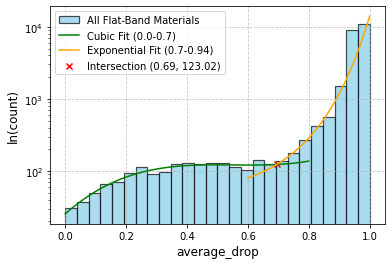

In [263]:
df_with_cuts = df_with_drops.copy()
#df_with_cuts = df_with_cuts[df_with_cuts["band_gap"]<=1]
# remove materials with no flat band below E_fermi
#df_with_cuts["flat_band_below_Ef"] = df_with_cuts["flat_segments"].apply(below_fermi)
#df_with_cuts = df_with_cuts[df_with_cuts["flat_band_below_Ef"]]

#get_selection_cut_histograms_and_power("av_drop", df_below_Ef)
#f_with_drops["half_av"] = (df_with_drops["av_drop"]+df_with_drops["min_drop"])/2
get_selection_cut_histograms_and_power("average_drop", df_with_cuts, save=True, name="fitted_hist.png", 
                                       N_bins=26, range_=(0.0,1), log_scale=True, apply_density=False)

In [80]:
#df_with_cuts = df_with_cuts[df_with_cuts["max_drop"]<0.7]
#df_with_cuts.sort_values(by=df_with_cuts.index, ascending=False)
df_with_drops.loc["mp-3006"]

flat                                                                    True
flat_segments                                                         [3, 4]
formula                                                              P2Pd3S8
synth_score                                                         0.333203
Cluster_ID                                                                -1
cluster_size                                                           24875
sublattice_element                                                        Pd
dbcv_cluster                                                         0.84682
probabilities                                                            0.0
paper_titles               [Verfeinerung der Kristallstruktur von Tripall...
experimentally_observed                                                 True
band_gap                                                              1.5779
synth_score_2                                                       0.978983

In [66]:
overlap_cutoff = 0.6

#temp_df = df_with_drops[df_with_drops["band_gap"]<=1]
temp_df = df_with_cuts

high_overlap_df = temp_df[temp_df["average_drop"]<=overlap_cutoff]
# Convert arrays to sets
# undoped SCs
#SCs = set(np.unique(df_3DSC[df_3DSC["SC_doped_from_original"]==False].index.to_numpy()))
SCs = set(np.unique(df_3DSC.index.to_numpy()))
# band gap <=1eV flat-mats
non_triv_flat_mats = set(np.unique(high_overlap_df.index.to_numpy()))

# full mat id list
full_ids = set(full_ids_list)

# insulating + non-flat mat id list
triv_plus_non_flat = full_ids.difference(non_triv_flat_mats)

# Find the common elements using intersection
num_nontriv_flat_SC = len(SCs.intersection(non_triv_flat_mats))
num_trivial_or_non_flat_SC = len(SCs.intersection(triv_plus_non_flat))
flat_check = full_ids.intersection(flat_mats)

# print outputs
print("Number of non-triv flat mats:", len(non_triv_flat_mats))
print("Number of trivial flat-band + non-flat-band mats:", len(triv_plus_non_flat))

print("number of 'non-trivial' flat-band SCs: ", num_nontriv_flat_SC)
print("number of 'trivial' or non-flat-band SCs: ", num_trivial_or_non_flat_SC)
#print("doped SC cases been removed: {0}".format())
print("% of SC non-triv flat mats:", (num_nontriv_flat_SC / len(non_triv_flat_mats))*100)
print("% of SC 'non-flat' or insulating mats:", (num_trivial_or_non_flat_SC / len(triv_plus_non_flat))*100)


Number of non-triv flat mats: 1460
Number of trivial flat-band + non-flat-band mats: 68991
number of 'non-trivial' flat-band SCs:  15
number of 'trivial' or non-flat-band SCs:  1246
% of SC non-triv flat mats: 1.0273972602739725
% of SC 'non-flat' or insulating mats: 1.806032670928092


In [104]:
df_with_drops.to_csv("df_with_final_MST_drop_scores.csv")

## Analyse atomic distances in flat-band sublattice (as determined by Anupam)

In [21]:
main_df["sub_lattice_structure"].to_list()[0]

"{'@module': 'pymatgen.core.structure', '@class': 'Structure', 'charge': 0, 'lattice': {'matrix': [[5.83749204, 0.06254491, -2.71890814], [-4.28350897, 3.9662647, -2.71900595], [0.02407769, 0.0625842, 6.43958097]], 'pbc': (True, True, True), 'a': 6.439929087854037, 'b': 6.439929978087647, 'c': 6.43993009173481, 'alpha': 114.75185786877043, 'beta': 114.75184782858017, 'gamma': 114.75183455160276, 'volume': 152.79889506945906}, 'properties': {}, 'sites': [{'species': [{'element': 'S', 'occu': 1}], 'abc': [0.24492283, 0.14077002, 0.90933939], 'xyz': [0.848640219099403, 0.6305601157552272, 4.807087432994953], 'properties': {'magmom': -0.0}, 'label': 'S'}, {'species': [{'element': 'S', 'occu': 1}], 'abc': [0.90933939, 0.24492283, 0.14077002], 'xyz': [4.262521728423524, 1.0371133042457898, -2.231856959615954], 'properties': {'magmom': -0.0}, 'label': 'S'}, {'species': [{'element': 'S', 'occu': 1}], 'abc': [0.14077002, 0.90933939, 0.24492283], 'xyz': [-3.067522386644024, 3.6308134704854167, -

In [22]:
# ADD LARGEST UNIT VECT TO DF - this shows a general way to add any structure info as a new column
def return_max_sublattice_vector(structure_dict):
    return max([structure_dict['lattice'][key] for key in ['a', 'b', 'c']])
def convert_string_to_dict(string_dict):
    return eval(string_dict)

def return_density(structure_dict):
    vectors = structure_dict['lattice']['matrix']
    a,b,c = vectors[0],vectors[1],vectors[2]
    volume = abs(np.dot(a,np.cross(b,c)))
    
    num_sites = len(structure_dict['sites'])
    
    return num_sites / volume 

In [23]:
main_df["sub_lattice_structure"] = main_df["sub_lattice_structure"].apply(convert_string_to_dict)
main_df["max_sub_unit_vector"] = main_df["sub_lattice_structure"].apply(return_max_sublattice_vector)

In [24]:
main_df["unit_cell_num_density"] = main_df["sub_lattice_structure"].apply(return_density)

In [25]:
get_selection_cut_histograms_and_power("unit_cell_num_density")
#plt.xlim([0,30])
#plt.ylim([0,0.5])

TypeError: get_selection_cut_histograms_and_power() missing 1 required positional argument: 'df_var'

## Location of Flat Bands

In [ ]:
def flat_below_fermi(flat_segments_list):
    return  (3 not in flat_segments_list) and (4 not in flat_segments_list)

In [ ]:
flat_below_fermi_mask = main_df.flat_segments.apply(flat_below_fermi)

In [ ]:
# get number of flat-below-fermi materials linked to a SC
num_below = flat_below_fermi_mask.sum()
below_sc_fraction = main_df[flat_below_fermi_mask].matched_to_a_sc.sum()/num_below
print("total # flat band materials:", len(main_df))
print("superconducting fraction (including doped and non-doped):", main_df.matched_to_a_sc.sum()/len(main_df))
print()

num_below = flat_below_fermi_mask.sum()
below_sc_fraction = main_df[flat_below_fermi_mask].matched_to_a_sc.sum()/num_below
print("# flat band materials which only have flat bands below the fermi level: ", num_below)
print("superconducting fraction:", below_sc_fraction)
print()

num_above = len(flat_below_fermi_mask)-num_below
above_sc_fraction = main_df[~flat_below_fermi_mask].matched_to_a_sc.sum()/num_above
print("# flat band materials which DON'T only have flat bands below the fermi level: ", num_above)
print("superconducting fraction:", above_sc_fraction)
print()
print("Ratio of fractions:", below_sc_fraction/above_sc_fraction)

# SC overlap with structure clusters

In [ ]:
num_sc_in_cluster = main_df["matched_to_a_sc"].groupby(main_df["Cluster_ID"]).sum()

In [ ]:
frac = num_sc_in_cluster / main_df["matched_to_a_sc"].groupby(main_df["Cluster_ID"]).count()
frac.sort_values(ascending=False)

In [ ]:
main_df["num_sc_in_cluster"] = main_df["Cluster_ID"].map(num_sc_in_cluster)
main_df["fraction_sc_in_cluster"] = main_df["num_sc_in_cluster"]/main_df["cluster_size"]

In [ ]:
#main_df["fraction_sc_in_cluster"]
df_sorted = main_df.sort_values(by='fraction_sc_in_cluster', ascending=False)
#df_sorted[df_sorted["experimentally_observed"]==False]
# Found a cluster with 1/3 matched superconductors ! CLUSTER ID: 90
# 114, 
#fraction[fraction==1/3]
main_df[main_df["Cluster_ID"]==131].head()
#df_sorted